## Библиотеки

In [1]:
!pip install transformers pymorphy2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.8 MB 6.8 MB/s 
     |████████████████████████████████| 55 kB 4.7 MB/s 
     |████████████████████████████████| 7.6 MB 70.6 MB/s 
     |████████████████████████████████| 182 kB 82.4 MB/s 
     |████████████████████████████████| 8.2 MB 53.8 MB/s 
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13723 sha256=85cb856b980114ff76d1853e82349bcc0318d413a541e76b36b02d3767f1f6e6
  Stored in directory: /root/.cache/pip/wheels/56/ea/58/ead137b087d9e326852a851351d1debf4ada529b6ac0ec4e8c
Successfully built docopt


In [2]:
from collections import Counter
import re
import pymorphy2
import nltk
import numpy as np
import pandas as pd
from nltk.tokenize import WordPunctTokenizer
nltk.download("stopwords")
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [3]:
morph = pymorphy2.MorphAnalyzer()
tokenizer = WordPunctTokenizer()
russian_stopwords = stopwords.words("russian")
    
    
def process_text(text):
    """
    Очищает текст
    """
    text = re.sub("_+", "", text) # Удаляет подчеркивания
    text = re.sub("\([^)]*\)", "", text) # Удаляет фразы в скобках (Фамилия имя отчество)
    text = text.lower()

    return text


def process_splitted_text(sequences):
    """
    Очищает список пунктов договора
    """
    result = [re.sub("\n", "", x) for x in sequences]
    result = [re.sub(r'\s+', ' ', x).strip() for x in sequences]

    return result


def splitting_text_by_regex(text, splitter='[\t\n]\s*\d+[0-9\.]*\.\s'):  # \d+\.[0-9\.]* - старый вариант (резал по отсылкам на пункты) #   \n\d+[0-9\.]*
    """
    Стандартный regex сплитит по пунктам договора
    """
    # TODO: Если не находит пункты, то пусть делит по абзацам
    points = re.findall(splitter, text)
    result = re.split(splitter, text)

    return result, points

## Загрузка данынх

In [4]:
import gdown

url = 'https://drive.google.com/file/d/1zfdnovlwsAyuv6NaWrNUBfgZxD-Fq3kG/view?usp=share_link'
gdown.download(url, "to_gdrive1.zip", fuzzy=True)
!unzip '/content/to_gdrive1.zip'

Downloading...
From: https://drive.google.com/uc?id=1zfdnovlwsAyuv6NaWrNUBfgZxD-Fq3kG
To: /content/to_gdrive1.zip
100%|██████████| 498k/498k [00:00<00:00, 75.1MB/s]

Archive:  /content/to_gdrive1.zip
  inflating: data.py                 
  inflating: model.py                
  inflating: text_data-3.csv         
  inflating: train.py                
  inflating: config.yml              


In [5]:
df = pd.read_csv("text_data-3.csv")
df

,text,label,doc_file_name
0,\nДоговор \n\n ...,Договоры для акселератора/Договоры поставки,4c2c295e81f4a6c3e669e8f76c6ce423.docx
1,\nДоговор поставки\n \nг. Новосибирск ...,Договоры для акселератора/Договоры поставки,856860329f573bbaf158e1eafa885ba5.docx
2,\n\n\t\t\n\nДОГОВОР ЗАКУПКИ № __________/\n\nг...,Договоры для акселератора/Договоры поставки,7eb67b5aecf3f3190aab0a5f8ea32172.docx
3,\nДоговор № {НомерДокумента}\n{НазваниеКонтр}...,Договоры для акселератора/Договоры поставки,84fec112d02288861e7af59f468131fb.docx
4,\nТИПОВОЙ ДОГОВОР\n\n\nг.___________ ...,Договоры для акселератора/Договоры поставки,64f58bc6e1207a570a38d771609b2cf1.docx
...,...,...,...
106,\nДОГОВОР КУПЛИ-ПРОДАЖИ ТОВАРА № _____ г. ____...,Договоры для акселератора/Договоры купли-продажи,abcec818adbe358f8071a75e0fe2cc49.pdf
107,\nПриложение № 6 \nк приказу от 29.12.2018 № 2...,Договоры для акселератора/Договоры оказания услуг,35b6a0f57d909507c5aa9a8972b15f35.pdf
108,\n(Типовая форма) \nДОГОВОР КУПЛИ -ПРОДАЖИ №_...,Договоры для акселератора/Договоры купли-продажи,086ad48895d2a73854b6151decc28800.pdf
109,\nСтраница 1 из 8 \n \nДОГОВОР КУПЛИ -ПРОДАЖИ...,Договоры для акселератора/Договоры купли-продажи,f57fe87f15a6dee2b17e804421be63b5.pdf


In [6]:
df.label.value_counts()

Договоры для акселератора/Договоры оказания услуг    29
Договоры для акселератора/Договоры аренды            21
Договоры для акселератора/Договоры купли-продажи     21
Договоры для акселератора/Договоры поставки          20
Договоры для акселератора/Договоры подряда           20
Name: label, dtype: int64

In [7]:
mapping = {"Договоры для акселератора/Договоры оказания услуг": 0,
           "Договоры для акселератора/Договоры купли-продажи": 1,
           "Договоры для акселератора/Договоры аренды": 2,
           "Договоры для акселератора/Договоры подряда": 3,
           "Договоры для акселератора/Договоры поставки": 4}

reversed_mapping = {
    0: "Договоры для акселератора/Договоры оказания услуг",
    1: "Договоры для акселератора/Договоры купли-продажи",
    2: "Договоры для акселератора/Договоры аренды",
    3: "Договоры для акселератора/Договоры подряда",
    4: "Договоры для акселератора/Договоры поставки"
}

In [8]:
df["label"] = df["label"].map(mapping)
df

,text,label,doc_file_name
0,\nДоговор \n\n ...,4,4c2c295e81f4a6c3e669e8f76c6ce423.docx
1,\nДоговор поставки\n \nг. Новосибирск ...,4,856860329f573bbaf158e1eafa885ba5.docx
2,\n\n\t\t\n\nДОГОВОР ЗАКУПКИ № __________/\n\nг...,4,7eb67b5aecf3f3190aab0a5f8ea32172.docx
3,\nДоговор № {НомерДокумента}\n{НазваниеКонтр}...,4,84fec112d02288861e7af59f468131fb.docx
4,\nТИПОВОЙ ДОГОВОР\n\n\nг.___________ ...,4,64f58bc6e1207a570a38d771609b2cf1.docx
...,...,...,...
106,\nДОГОВОР КУПЛИ-ПРОДАЖИ ТОВАРА № _____ г. ____...,1,abcec818adbe358f8071a75e0fe2cc49.pdf
107,\nПриложение № 6 \nк приказу от 29.12.2018 № 2...,0,35b6a0f57d909507c5aa9a8972b15f35.pdf
108,\n(Типовая форма) \nДОГОВОР КУПЛИ -ПРОДАЖИ №_...,1,086ad48895d2a73854b6151decc28800.pdf
109,\nСтраница 1 из 8 \n \nДОГОВОР КУПЛИ -ПРОДАЖИ...,1,f57fe87f15a6dee2b17e804421be63b5.pdf


In [9]:
def create_sentences(df, content_column="text", label_column="label", id_column="doc_file_name") -> pd.DataFrame:
    """
    Из датафрейма с договорами создает большой датафрейм пунктов и лейблов к ним
    """
    text_data = []
    labels_data = []
    id_data = []

    for index in range(df.shape[0]):
        row = df.iloc[index]
        splitted_text, splitting_points = splitting_text_by_regex(process_text(row[content_column]))
        if len(splitted_text) < 5:
            splitted_text_by_enter = []
            for text in splitted_text:
                splitted_text_by_enter.extend(text.split('\n'))
            splitted_text = splitted_text_by_enter
        
        splitted_text_by_enter = []
        for text in splitted_text:
            if len(text.split(' ')) > 600: # > 600 слов => разбиение по \n
                splitted_text_by_enter.extend(text.split('\n'))
            else:
                splitted_text_by_enter.append(text)

        splitted_text = splitted_text_by_enter
        


        processed_splitted_text = process_splitted_text(splitted_text)

        text_data += processed_splitted_text
        
        labels_data.extend(row[label_column] for x in range(len(processed_splitted_text)))
        id_data.extend(re.sub(r"\.+[^\n]+", "", row[id_column]) for x in range(len(processed_splitted_text)))

    sentences = pd.DataFrame({"text": text_data, "label": labels_data, "id": id_data})

    filtered = sentences[sentences["text"].apply(lambda x: len(x.split(" ")) > 5)].reset_index(drop=True)
    #.reset_index(drop=True)

    return filtered

## ```Deep-Pavlov-Rubert``` cross validation (5-Fold)

In [10]:
import yaml

with open("/content/config.yml", "r") as yamlfile:
    cfg = yaml.safe_load(yamlfile)
    print("Read successful")
print(cfg)

Read successful
{'data': {'labeled_df_filename': '/content/dataset/train.tsv', 'unlabeled_df_filename': '/content/dataset/test.tsv', 'train_size': 0.8, 'val_size': 0.2}, 'model': {'model_name': 'DeepPavlov/rubert-base-cased', 'max_seq_length': 128, 'num_classes': 5, 'dropout': 0.25}, 'training': {'learning_rate': '3e-5', 'adam_epsilon': '1e-8', 'num_epochs': 3, 'batch_size': 16}, 'general': {'seed': 42}}


In [11]:
from typing import List, Mapping, Tuple

import pandas as pd
import torch
from torch.utils.data import DataLoader, Dataset, RandomSampler, SequentialSampler
torch.manual_seed(42)

from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer


class TextClassificationDataset(Dataset):
    
    def __init__(
        self, 
        texts: List[str], 
        labels: List[int] = None,
        labels_dict: Mapping[str,str] = None,
        max_seq_length: int = 128,
        model_name: str = None,
        add_spec_tokens: bool = False,
    ):
        """
        Args:
            texts: a list of text to classify
            labels: a list with classification labels
            labels_dict: a dictionary mapping class names to class ids
            max_seq_length: maximum sequence length in tokens
            model_name: transformer model name
            add_spec_tokens: if we want to add special tokens to the tokenizer
        """
        
        self.texts = texts
        self.labels = labels
        self.labels_dict = labels_dict
        self.max_seq_length = max_seq_length
        
        # labels_dict = {'class1' : '0', 'class2' : '1', 'class3' : '2', ...}
        if (self.labels_dict is None and labels is not None): 
            self.labels_dict = dict(zip(sorted(set(labels)), range(len(set(labels)))))

        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        # May add special tokens option later ( ['URL'], ['HASHTAG'], ['MENTION'], ['NUM'], ... ) 
         
    def __len__(self) -> int:
        return len(self.texts)
        
    def __getitem__(self, index : int) -> Mapping[str, torch.Tensor]:
        """
        Gets encoded representation of a single element (text) in the dataset
        Args:
            index (int): index of the element in dataset
        Returns:
            Single element by index
        """
        text = self.texts[index]
        
        # A dictionary with 'input_ids', 'token_type_ids', 'attention_masks' as keys
        encoded_dict = self.tokenizer.encode_plus(
            text,                      
            add_special_tokens = True, 
            max_length = self.max_seq_length,
            pad_to_max_length = True,
            return_attention_mask = True,
            return_tensors = 'pt',   
        )

        encoded_dict["features"] = encoded_dict["input_ids"].squeeze(0)
        del encoded_dict["input_ids"]
        del encoded_dict["token_type_ids"] # don't need them because they are for sequence-pair classification task
       
        # Encoding target label using our labels_dict
        if self.labels is not None:
            y = self.labels[index]
            y_encoded = torch.Tensor([self.labels_dict.get(y, -1)]).long().squeeze(0)
            encoded_dict["targets"] = y_encoded

        return encoded_dict
    
def read_data(cfg: dict) -> Tuple[dict, dict, dict]:
    """
    Function that reads text data, creates TextClassificationDatasets and DataLoaders. 
    Args:
        A config dictionary containing "file_path", "max_seq_length", etc...
    Returns: 
        A tuple with (training & validation), testing, unlabeled_inference DataLoader dictionaries
    """
    
    # Creating PyTorch Datasets
    train_dataset = TextClassificationDataset(
        texts=train_sentences['text'].values.tolist(),
        labels=train_sentences['label'].values,
        max_seq_length=cfg['model']['max_seq_length'], 
        model_name=cfg['model']['model_name'],
    )

    val_dataset = TextClassificationDataset(
        texts=test_sentences['text'].values.tolist(),
        labels=test_sentences['label'].values,
        max_seq_length=cfg['model']['max_seq_length'], 
        model_name=cfg['model']['model_name'],
    )

    # Create the DataLoaders for our training and validation sets.
    # We'll take training samples in random order. 
    
    train_loader = DataLoader(
        dataset=train_dataset,
        sampler=RandomSampler(train_dataset),
        batch_size=cfg['training']['batch_size'],
    )
        
    val_loader = DataLoader(
        dataset=val_dataset,
        sampler=SequentialSampler(val_dataset),
        batch_size=cfg['training']['batch_size'],
    )

    
    return train_loader, val_loader

0it [00:00, ?it/s]


Fold 0:

  Train: index = [ 23  24  25  26  27  28  29  30  31  32  33  34  35  36  37  38  39  40
  41  42  43  44  45  46  47  48  49  50  51  52  53  54  55  56  57  58
  59  60  61  62  63  64  65  66  67  68  69  70  71  72  73  74  75  76
  77  78  79  80  81  82  83  84  85  86  87  88  89  90  91  92  93  94
  95  96  97  98  99 100 101 102 103 104 105 106 107 108 109 110]

  Test:  index = [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22]



Downloading:   0%|          | 0.00/24.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/642 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.65M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/714M [00:00<?, ?B/s]

Some weights of the model checkpoint at DeepPavlov/rubert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).

  0%|          | 0/3 [00:00<?, ?it/s]


Epoch = 0



Validating: 100%|██████████| 84/84 [00:10<00:00,  8.33it/s]


Validation acc = 1.0; F1 = 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00         3
           2       1.00      1.00      1.00         1
           3       1.00      1.00      1.00         5
           4       1.00      1.00      1.00        10

    accuracy                           1.00        23
   macro avg       1.00      1.00      1.00        23
weighted avg       1.00      1.00      1.00        23

[[ 4  0  0  0  0]
 [ 0  3  0  0  0]
 [ 0  0  1  0  0]
 [ 0  0  0  5  0]
 [ 0  0  0  0 10]]
AxesSubplot(0.125,0.125;0.62x0.755)


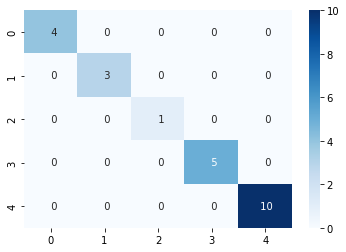

=> Saving checkpoint at epoch 0



 33%|███▎      | 1/3 [01:47<03:35, 107.52s/it]


Epoch = 1



Validating: 100%|██████████| 84/84 [00:10<00:00,  8.34it/s]

 67%|██████▋   | 2/3 [03:32<01:46, 106.25s/it]

Validation acc = 1.0; F1 = 1.0

Epoch = 2



Validating: 100%|██████████| 84/84 [00:10<00:00,  8.35it/s]

100%|██████████| 3/3 [05:18<00:00, 106.28s/it]
1it [05:44, 344.44s/it]

Validation acc = 1.0; F1 = 1.0

Fold 1:

  Train: index = [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  45  46  47  48  49  50  51  52  53  54  55  56  57
  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72  73  74  75
  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90  91  92  93
  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108 109 110]

  Test:  index = [23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44]



Some weights of the model checkpoint at DeepPavlov/rubert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).

  0%|          | 0/3 [00:00<?, ?it/s]


Epoch = 0



Validating: 100%|██████████| 62/62 [00:07<00:00,  8.78it/s]


Validation acc = 0.9545454545454546; F1 = 0.9533648170011806
              precision    recall  f1-score   support

           0       0.83      1.00      0.91         5
           1       1.00      1.00      1.00         4
           2       1.00      1.00      1.00         2
           3       1.00      0.75      0.86         4
           4       1.00      1.00      1.00         7

    accuracy                           0.95        22
   macro avg       0.97      0.95      0.95        22
weighted avg       0.96      0.95      0.95        22

[[5 0 0 0 0]
 [0 4 0 0 0]
 [0 0 2 0 0]
 [1 0 0 3 0]
 [0 0 0 0 7]]
AxesSubplot(0.125,0.125;0.62x0.755)


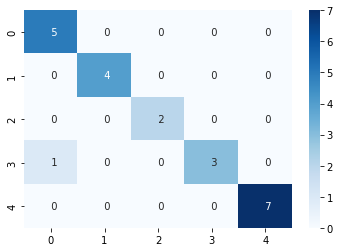

=> Saving checkpoint at epoch 0



 33%|███▎      | 1/3 [01:51<03:43, 112.00s/it]


Epoch = 1



Validating: 100%|██████████| 62/62 [00:07<00:00,  8.82it/s]

 67%|██████▋   | 2/3 [03:40<01:50, 110.14s/it]

Validation acc = 0.9545454545454546; F1 = 0.9533648170011806

Epoch = 2



Validating: 100%|██████████| 62/62 [00:07<00:00,  8.59it/s]

100%|██████████| 3/3 [05:30<00:00, 110.01s/it]
2it [11:18, 338.18s/it]

Validation acc = 0.9545454545454546; F1 = 0.9533648170011806

Fold 2:

  Train: index = [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  67  68  69  70  71  72  73  74  75
  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90  91  92  93
  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108 109 110]

  Test:  index = [45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66]



Some weights of the model checkpoint at DeepPavlov/rubert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).

  0%|          | 0/3 [00:00<?, ?it/s]


Epoch = 0



Validating: 100%|██████████| 65/65 [00:07<00:00,  8.72it/s]


Validation acc = 0.9545454545454546; F1 = 0.9513368983957219
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         8
           1       1.00      0.67      0.80         3
           2       0.89      1.00      0.94         8
           3       1.00      1.00      1.00         3

    accuracy                           0.95        22
   macro avg       0.97      0.92      0.94        22
weighted avg       0.96      0.95      0.95        22

[[8 0 0 0]
 [0 2 1 0]
 [0 0 8 0]
 [0 0 0 3]]
AxesSubplot(0.125,0.125;0.62x0.755)


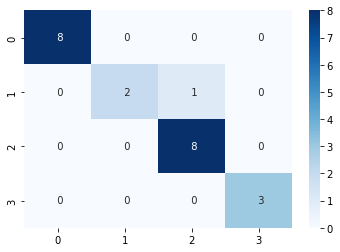

=> Saving checkpoint at epoch 0



 33%|███▎      | 1/3 [01:50<03:41, 110.93s/it]


Epoch = 1



Validating: 100%|██████████| 65/65 [00:07<00:00,  8.75it/s]

 67%|██████▋   | 2/3 [03:38<01:49, 109.13s/it]

Validation acc = 0.9090909090909091; F1 = 0.9090909090909091

Epoch = 2



Validating: 100%|██████████| 65/65 [00:07<00:00,  8.57it/s]

100%|██████████| 3/3 [05:26<00:00, 108.93s/it]
3it [16:48, 334.63s/it]

Validation acc = 0.9545454545454546; F1 = 0.9513368983957219

Fold 3:

  Train: index = [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  89  90  91  92  93
  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108 109 110]

  Test:  index = [67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88]



Some weights of the model checkpoint at DeepPavlov/rubert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).

  0%|          | 0/3 [00:00<?, ?it/s]


Epoch = 0



Validating: 100%|██████████| 55/55 [00:06<00:00,  8.20it/s]


Validation acc = 0.9090909090909091; F1 = 0.9085399449035813
              precision    recall  f1-score   support

           0       1.00      0.83      0.91         6
           1       0.88      1.00      0.93         7
           2       1.00      1.00      1.00         5
           3       0.75      0.75      0.75         4

    accuracy                           0.91        22
   macro avg       0.91      0.90      0.90        22
weighted avg       0.91      0.91      0.91        22

[[5 0 0 1]
 [0 7 0 0]
 [0 0 5 0]
 [0 1 0 3]]
AxesSubplot(0.125,0.125;0.62x0.755)


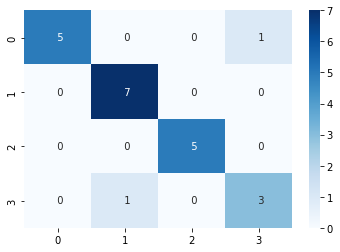

=> Saving checkpoint at epoch 0



 33%|███▎      | 1/3 [01:55<03:51, 115.87s/it]


Epoch = 1



Training loss: 2.61e-01; lr: 1.93e-05:   7%|▋         | 20/275 [00:07<01:35,  2.66it/s]

In [ ]:
from train import run
from tqdm import tqdm
from sklearn.model_selection import KFold
from model import BertForSequenceClassification

kf = KFold(n_splits=5)
kf.get_n_splits(df[["text", "doc_file_name"]])

# train запускается по 3 эпохи (лучший предикт выдаёт чаще всего сразу после 1ой эпохи) на каждом из 5 фолдов
# чтобы запускать по 1ой эпохе, нужно поменять в cfg.yaml число num_epochs с 3ёх на 1

for i, (train_index, test_index) in tqdm(enumerate(kf.split(df[["text", "doc_file_name"]]))):
    print()
    print("====================================")
    print(f"Fold {i}:")
    print("====================================\n")
    print(f"  Train: index = {train_index}\n")
    print(f"  Test:  index = {test_index}\n")

    # X_train -> df[["text", "doc_file_name"]].iloc[train_index]
    # y_train -> df['label'].iloc[train_index] 
    # X_test -> df[["text", "doc_file_name"]].iloc[test_index]
    # y_test -> df['label'].iloc[test_index]

    train_sentences = create_sentences(pd.concat([df[["text", "doc_file_name"]].iloc[train_index], 
                                                  df['label'].iloc[train_index]], axis=1))
    test_sentences = create_sentences(pd.concat([df[["text", "doc_file_name"]].iloc[test_index], 
                                                 df['label'].iloc[test_index]], axis=1))
    
    train_dataloader, val_dataloader = read_data(cfg) # dataloaders for train_sentences, test_sentences
    
    # storing our errors & scores for further plt.plotting
    train_losses = []
    val_losses = []
    F1_scores = []
    accuracy_scores = []

    model = BertForSequenceClassification(
        pretrained_model_name='DeepPavlov/rubert-base-cased',
        num_labels=cfg['model']['num_classes'], # 5
        dropout=cfg['model']['dropout'], # 0.25
    )

    run(model=model,
      cfg=cfg,
      train_dataloader=train_dataloader,
      val_dataloader=val_dataloader,
      unlabeled_dataloader=None,
      test_sentences=test_sentences,
      y_test=df['label'].iloc[test_index].to_list(),
      train_losses=train_losses,
      val_losses=val_losses,
      F1_scores=F1_scores,
      accuracy_scores=accuracy_scores,
    )


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

!ls /content/gdrive # вывести контент на диске

In [ ]:
# Сохранить веса модели на лучшей эпохе на gdrive

model_save_name = 'DeepPavlov-Ru-bert-fine-tuned.pt'
path = F"/content/gdrive/My Drive/{model_save_name}" 
torch.save(model.state_dict(), path)